# Data Quality Assessment 

First stage was to assess the data quality, in order to ascern whether exploring data quality within the skin lesion dataset would be a variable investigation. To do this we used the PyTorch Image Quality (PIQ) package, further information available at: https://github.com/photosynthesis-team/piq 
 and package documentation at: https://piq.readthedocs.io/en/latest/functions.html

We have initally chosen, Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE) and Total Variation, as both of these are No Reference Metrics. 
 

In [1]:
!pip install piq

     |████████████████████████████████| 127 kB 30.0 MB/s 


In [2]:
import torch
from piq import brisque, total_variation

In [25]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision.transforms as transforms
from os import listdir, path
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np

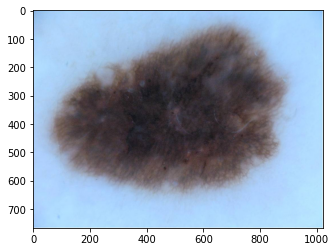

In [ ]:
test_image = io.imread("/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0000000.jpg")
plt.imshow(test_image)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
  
# Convert the image to Torch tensor
# tensor = transform(test_image)

# # expand out dimenstions to 4, as axpected by image quality metrics 
# four_ten = tensor.reshape(1, *tensor.shape)

# brisque_index = brisque(four_ten)

# print(brisque_index)


In [9]:
#Creating function to iterate over individual images, claculate BRISQUE or TV score, then append each score to a list

from multiprocessing import Pool, Manager

def calculate_metric(metric, image_file_path, metric_scores):
    original_image = io.imread(image_file_path)

    #Convert the image to Torch tensor
    tensor = transform(original_image)
    # expand out dimenstions to 4, as axpected by image quality metrics 
    four_ten = tensor.reshape(1, *tensor.shape)

    #calculating metric
    metric_value = metric(four_ten)
    metric_scores[image_file_path] = metric_value.item()


def quality_assessment (metric, image_folder):
    images = []

    # getting the sorted list of file names and number of images
    file_names = sorted(listdir(image_folder))
    no_images = len(file_names)

    # initialising subplot index
    subplot_index = 1

    metric_scores = Manager().dict()

    params = []
  
    # iterating over images
    for i, image_file in enumerate(file_names, start=1):
        #loading original image
        image_file_path = path.join(image_folder, image_file)
        params.append((metric, image_file_path, metric_scores))

    with Pool(4) as p:
        print("Running pool")
        p.starmap(calculate_metric, tqdm(params, total=len(params)))

    return dict(metric_scores)

## BRISQUE 

In [ ]:
image_folder = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input"

brisque_metrics = quality_assessment(brisque, image_folder)

Running pool


100%|██████████| 25331/25331 [49:42<00:00,  8.49it/s]


In [66]:
import json
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/brisque_metrics.json", "w") as f:
    json.dump(brisque_metrics, f, indent=4)


In [ ]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/brisque_metrics.json", "r") as f:
    brisque_metrics_reopened = json.load(f)

In [28]:
brisque_values = brisque_metrics_reopened.values()
brisque_mean = mean(brisque_values)
print(brisque_mean)

37.140636510202576
25.707741485233676


(0.0, 1000.0)

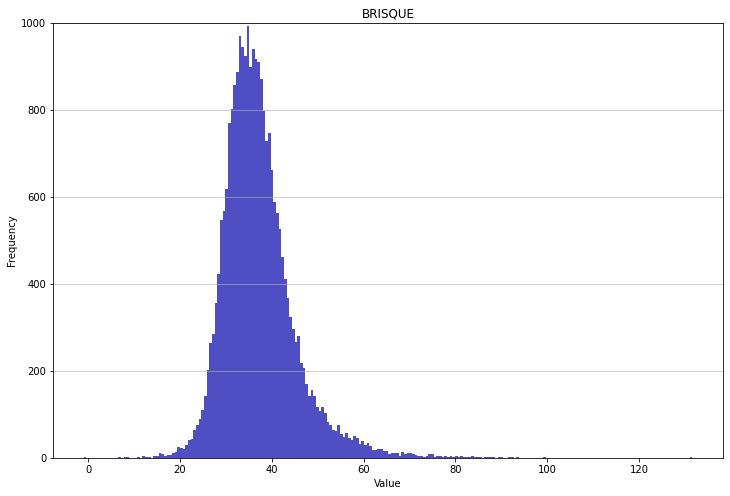

In [44]:
# Histogram for BRISQUE 
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(x=brisque_values, bins='auto', color='#0504aa',
                            alpha=0.7)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('BRISQUE')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

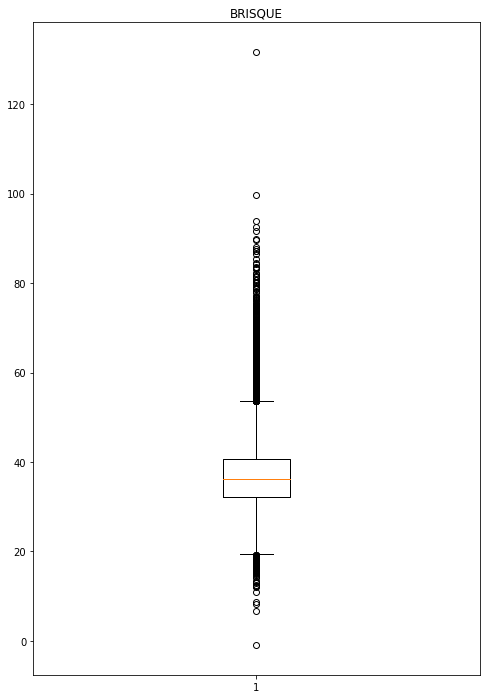

In [55]:
# box plot for BRISQUE
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(1,1,1)
ax.boxplot(brisque_values)
ax.set_title('BRISQUE')
plt.show()

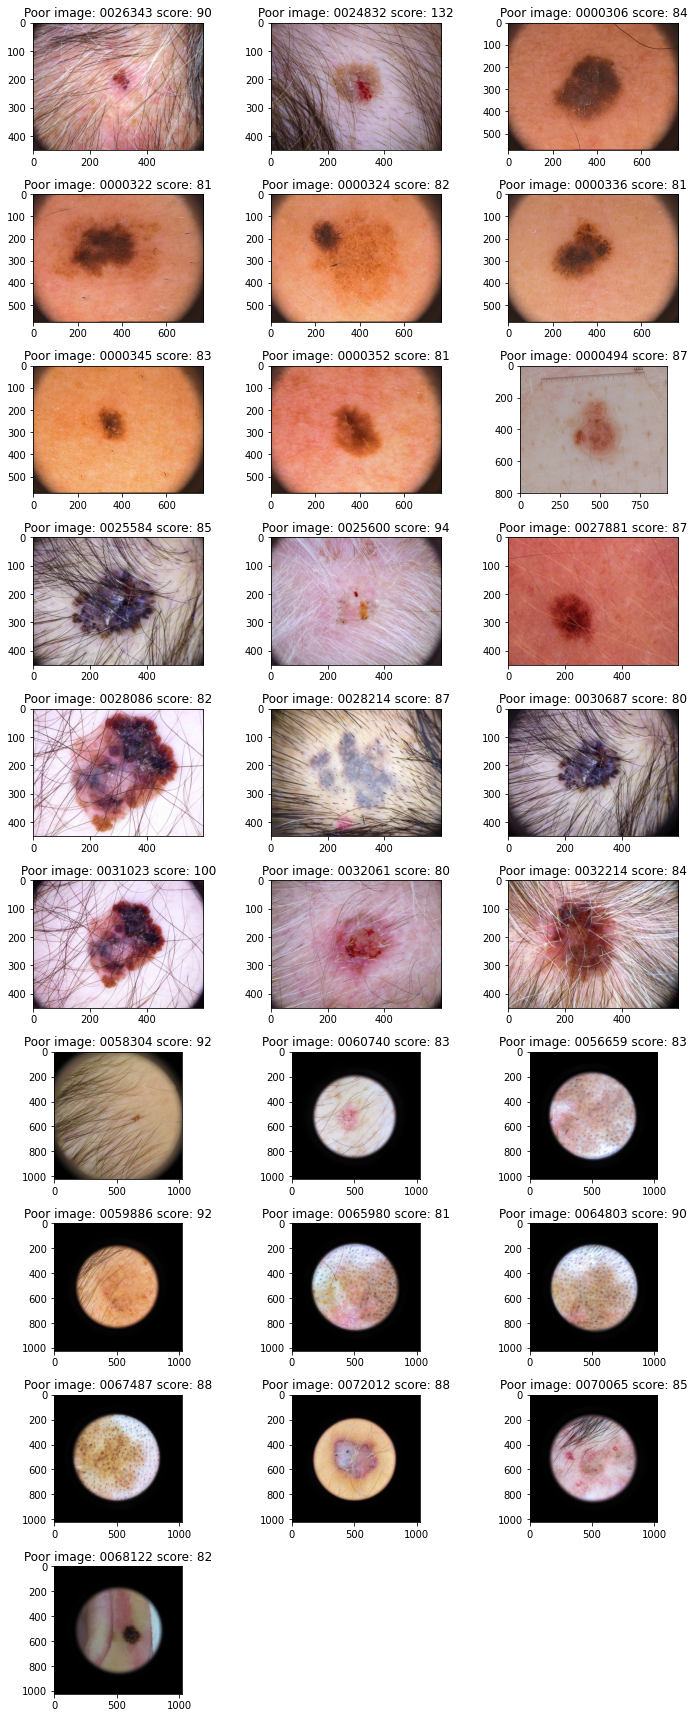

In [128]:
# visulisation images with a high (and therefore poor) BRISQUE quality score of greater than 80 and lower than 20

# greater than 80
poor_brisq = {k: v for k, v in brisque_metrics_reopened.items() if v >= 80}
#len(poor_brisq)
#28

#initialising subplot index
subplot_index = 1
no_images = len(poor_brisq)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(poor_brisq.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Poor image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()

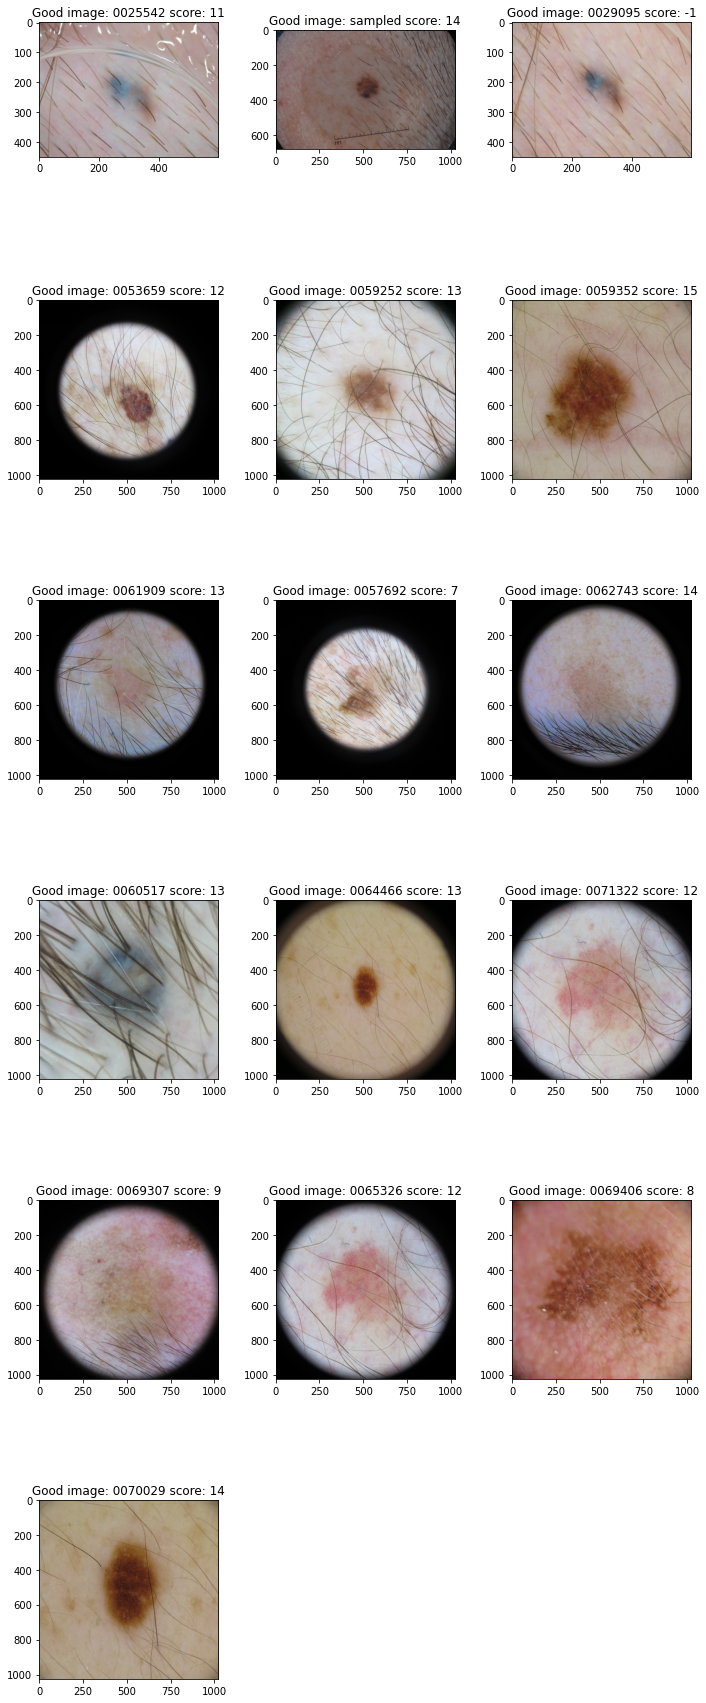

In [134]:
## GOOD BRISQUE SCORE

# smaller than 20
good_brisq = {k: v for k, v in brisque_metrics_reopened.items() if v <= 15}

#initialising subplot index
subplot_index = 1
no_images = len(good_brisq)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(good_brisq.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Good image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()


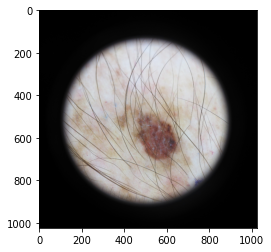

In [116]:
good_images_names

test_good = io.imread('/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0053659.jpg')
plt.imshow(test_good)

In [120]:
# middle images mean is 37.14

# middle of curve area 37-38
# middle_brisq = dict((k, v) for k, v in brisque_metrics_reopened.items() if  v == 37.14)
# len(middle_brisq)
# 9649

9649

## Total Variation

In [10]:
image_folder = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input"
total_variation_metrics = quality_assessment(total_variation, image_folder)

Running pool


100%|██████████| 25331/25331 [20:04<00:00, 21.03it/s]


In [12]:
import json
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/total_variation_metrics.json", "w") as f:
    json.dump(total_variation_metrics, f, indent=4)

In [56]:
total_variation_values = total_variation_metrics.values()
tv_mean = mean(total_variation_values)
print(tv_mean)

25.707741485233676


(0.0, 1270.0)

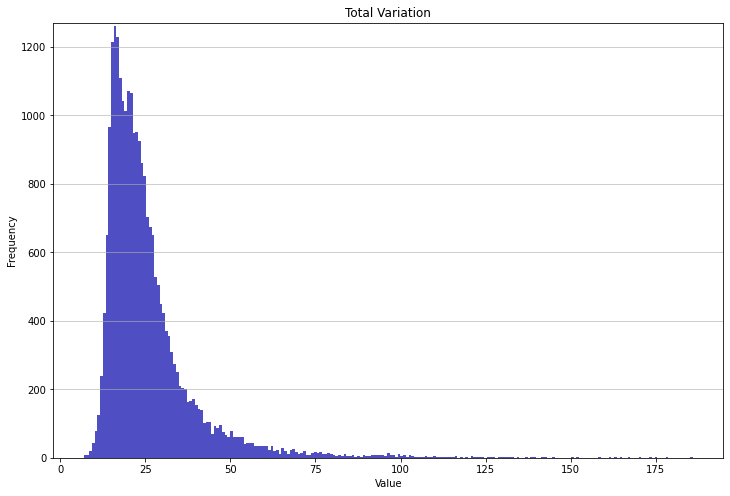

In [57]:
# Histogram for TV
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(x=total_variation_values, bins='auto', color='#0504aa',
                            alpha=0.7)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total Variation')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

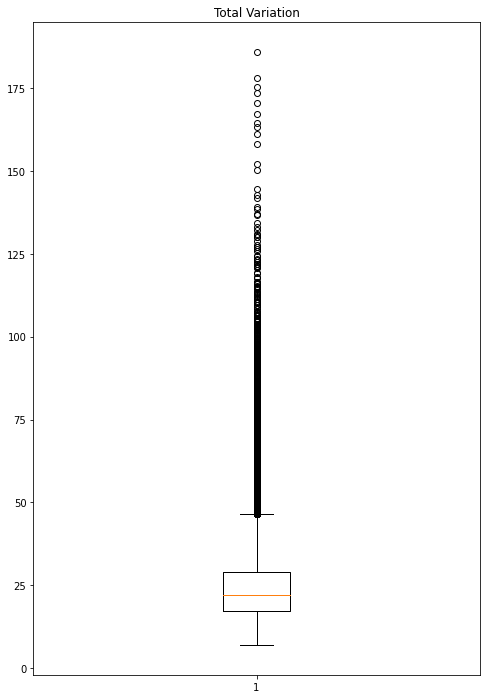

In [58]:
# box plot for TV
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(1,1,1)
ax.boxplot(total_variation_values)
ax.set_title('Total Variation')
plt.show()